# Goals

- Scrap transfermarket webpage for the market value of Premier League and Championship teams over the last 10 years
- Analyze the evolution of the market value
- Study the correlation between market value and final league standings. Identify which teams underperformed and overperformed.

In [1]:
from tqdm.notebook import tqdm

In [2]:
import requests
from bs4 import BeautifulSoup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

First we look for at which dates the TransferMarket Value (TMValue) is available. A quick glance first suggested the data is available every 1st and 15th of every month since 2010-10-01, however there are (at least) some inconsistencies in 2014.

In [4]:
dates_available = []
headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

page = 'https://www.transfermarkt.com/premier-league/marktwerteverein/wettbewerb/GB1/plus/?stichtag=2022-09-01'
pageTree = requests.get(page, headers=headers)
pageSoup = BeautifulSoup(pageTree.content, 'html.parser')
for i in range(len(pageSoup.find_all("option"))):
    dates_available.append(pageSoup.find_all("option")[i].get('value'))

Now that we have the dates for which data is available, we scrap the data. A limitation from the data here is that the data is gathered from the teams currently in the Premier League, Championship and League One. If at the time the search is done a team, previously in Premier League is no longer in either of these leagues, no data will be gathered. Since we are interested in forecasting teams in the Premier League based on data from the past few years this will hopefully capture the TMValue for all teams we need.

In [5]:
# Links to the webpages for the Premier League and Championship
links = {
    'premierleague': lambda date: f'https://www.transfermarkt.com/premier-league/marktwerteverein/wettbewerb/GB1/plus/?stichtag={date}',
    'championship': lambda date: f'https://www.transfermarkt.com/championship/marktwerteverein/wettbewerb/GB2/plus/?stichtag={date}',
    'leagueone': lambda date: f'https://www.transfermarkt.com/league-one/marktwerteverein/wettbewerb/GB3/plus/?stichtag={date}'
}

# The code to scrap the data was inspired by https://fcpython.com/blog/introduction-scraping-data-transfermarkt
entries = []
for date in tqdm(dates_available, desc='Dates'):
    for league in links:
        headers = {'User-Agent': 
                   'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

        page = links[league](date)
        pageTree = requests.get(page, headers=headers)
        pageSoup = BeautifulSoup(pageTree.content, 'html.parser')
        Clubs = pageSoup.find_all("td", {"class": "hauptlink no-border-links"})
        TMValues = pageSoup.find_all("td", {"class": "rechts"})

        for i in range(len(Clubs)):
            club_name = Clubs[i].text
            tmvalue_string = TMValues[3+i*3].text[1:]
            if 'bn' in tmvalue_string:
                tmvalue = float(tmvalue_string[:-2])*1000
            elif 'm' in tmvalue_string:
                tmvalue = float(tmvalue_string[:-1])
            entries.append((date, club_name, tmvalue))

Dates:   0%|          | 0/277 [00:00<?, ?it/s]

In [6]:
df = pd.DataFrame(entries, columns=['Date', 'Team', 'TMValue'])

In [9]:
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")

In [11]:
df.to_csv('raw_data/transfermarkt/TMValueEngland.csv', index=False)

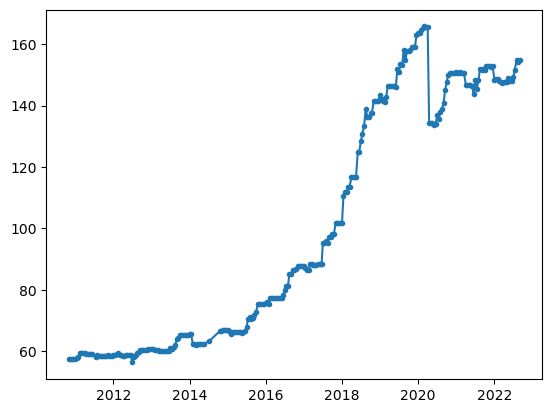

In [12]:
plt.plot(df.groupby('Date').mean().index, df.groupby('Date').mean()['TMValue'].values,'.-')

The significant drop seen in the graph between the period 2020-04-01 and 2020-04-15 is the result of the COVID19 pandemic. "Transfermarkt [...] reacted to the exceptional situation with the unprecedented step of making a global market value cut of 20% – players born in 1998 or later will be downgraded by 10%."

Source: https://www.transfermarkt.us/reaction-to-corona-majority-of-players-downgraded-loss-of-over-euro-9-billion-worldwide/view/news/358336